In [29]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False


# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [30]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [31]:

import os
image_raw = tf.io.read_file(os.path.join('data', 'YellowLabradorLooking_new.jpg'))
image = tf.image.decode_image(image_raw)
image = tf.cast(image, tf.float32)
image = tf.image.resize(image, (224, 224))
image = image[None, ...]

image = tf.keras.applications.mobilenet_v2.preprocess_input(image)


image_probs = pretrained_model.predict(image)


1/1 [==============================] - 1s 695ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


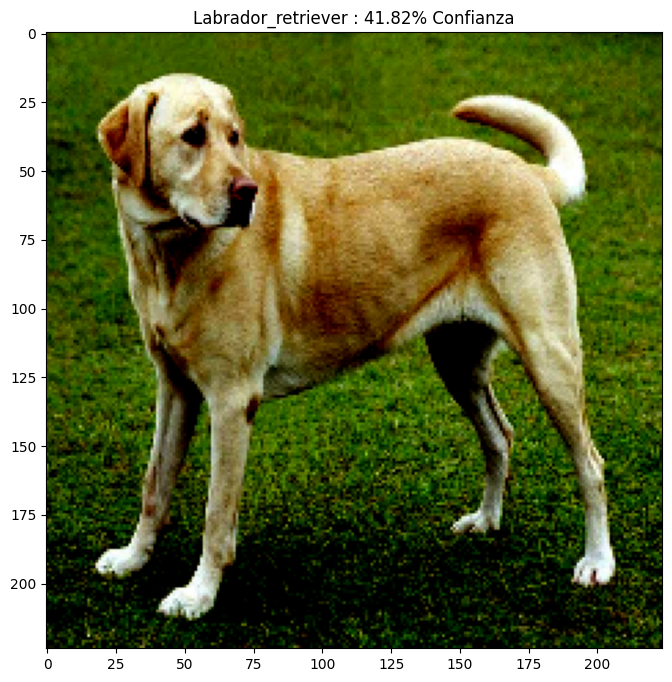

In [32]:
plt.figure()
plt.imshow(image[0])  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confianza'.format(image_class, class_confidence*100))
plt.show()

In [33]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [34]:
labrador_retriever_index = 208

image_probs

array([[8.85022921e-04, 6.28016191e-04, 7.25384816e-05, 9.64738065e-05,
        4.41165175e-04, 3.66970518e-04, 6.85218256e-05, 1.86478574e-04,
        3.58789111e-04, 1.13704613e-04, 3.58338410e-04, 5.78533800e-04,
        3.52156465e-04, 5.33190905e-04, 1.84150354e-04, 1.37820534e-04,
        1.31516805e-04, 2.76529288e-04, 1.84453456e-04, 2.82052468e-04,
        1.69199295e-04, 1.36496426e-04, 3.06018541e-04, 9.59250901e-05,
        1.91388128e-04, 6.04510424e-04, 5.20505637e-05, 1.55968184e-04,
        3.35875637e-04, 2.73080310e-04, 3.19335260e-04, 4.51542030e-04,
        1.02227095e-04, 1.43173602e-04, 1.28488231e-04, 7.87711702e-04,
        1.44466030e-04, 1.10740337e-04, 2.15368942e-04, 2.57171720e-04,
        6.42016414e-04, 1.50511143e-04, 1.66814963e-04, 2.18009809e-04,
        1.84889257e-04, 1.94990265e-04, 6.34303491e-04, 4.16065537e-04,
        2.08286772e-04, 1.04576022e-04, 3.44008644e-04, 1.66542668e-04,
        1.83545286e-04, 4.74900335e-05, 1.67607504e-04, 6.982241

In [35]:
image_probs.shape

(1, 1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


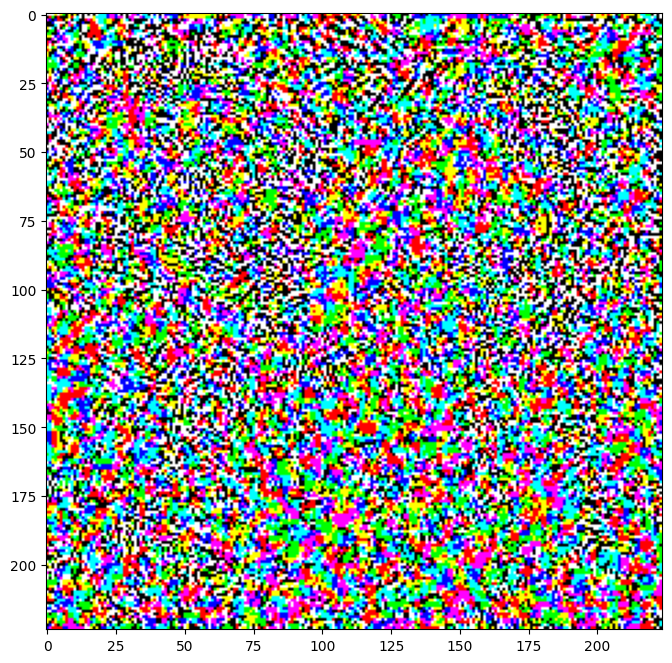

In [36]:
# Get the input label of the image.
label = tf.one_hot(208, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0]);  # To change [-1, 1] to [0,1]

In [37]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0])
  plt.title('{} \n {} : {:.2f}% Confianza'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


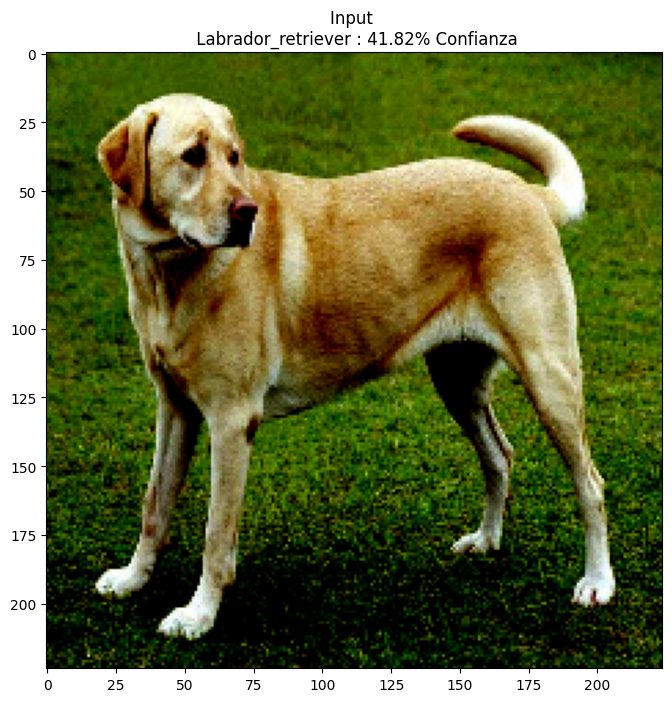

1/1 [==============================] - 0s 122ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


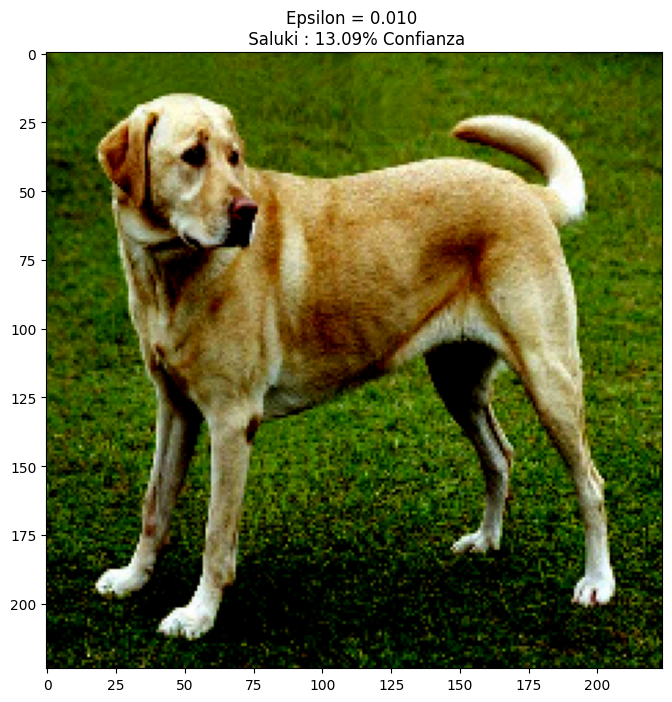

1/1 [==============================] - 0s 95ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


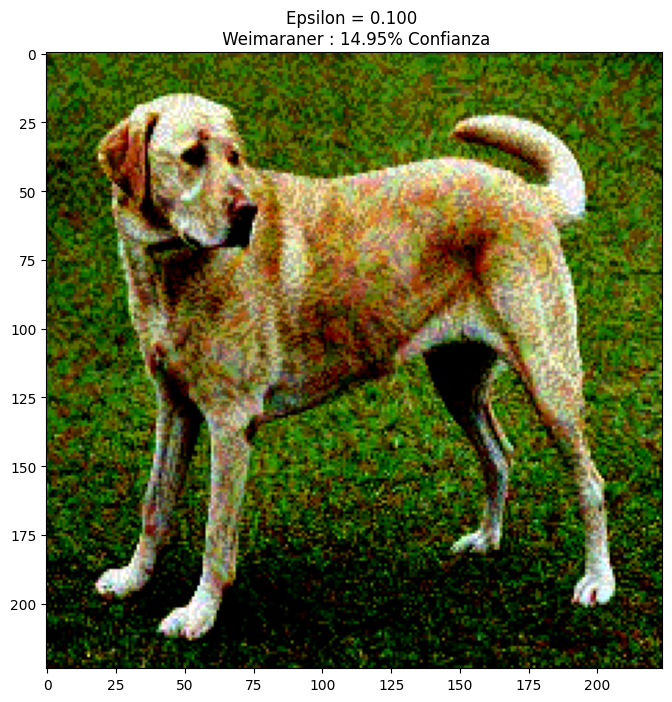

1/1 [==============================] - 0s 42ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


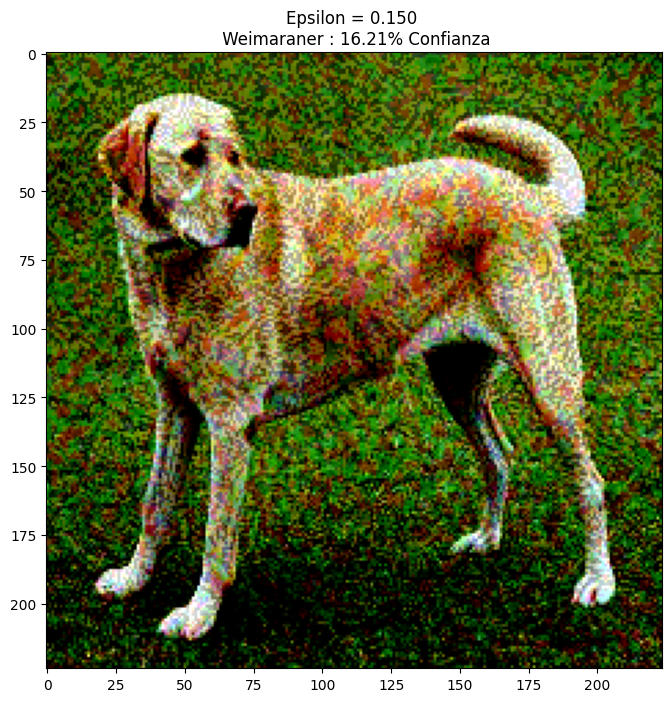

In [38]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])